In [1]:
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

from metrics import get_acc, get_jsd, get_auc, add_preds, acc_buckets, get_kappa_mcqs, get_diffp


/is/sg2/sgoel/miniconda3/envs/diff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
preds = {}
shared_name = "shared_new_3"
test_name = "test_new_3"
model_names = ["weak_base", "weak_ft", "strong_base", "w2s", "strong_ft"]
datasets = ["anli-r2", "boolq", "cola", "ethics-utilitarianism", "hellaswag", "sciq", "piqa", "sst2", "twitter-sentiment"]
datasplits = ['test'] #["train", "val", "test"]

#ALT CONFIG
# model_names = ["weak_ft", "strong_ft", "w2s"]
# shared_name = "shared3"
# test_name = "test3"

for dname in datasets:
    print(f"Dataset: {dname}")
    preds[dname] = {}
    for mname in model_names:
        print(f"Model: {mname}")
        preds[dname][mname] = {}
        mfilename = mname
        if mname.endswith("ft"):
            mfilename = mname[:-3]
        folder_name = test_name if mname == "w2s" else shared_name
        for split in datasplits:
            preds[dname][mname][split] = add_preds(Dataset.from_file(f"results/{folder_name}/{dname}/{mfilename}/predictions/{split}/data-00000-of-00001.arrow"))
            print(f"Loaded {len(preds[dname][mname][split])} examples for {split} split, accuracy: {get_acc(preds[dname][mname][split]):.2f}%, auc: {get_auc(preds[dname][mname][split]):.2f}")

Dataset: anli-r2
Model: weak_base
Loaded 668 examples for test split, accuracy: 50.60%, auc: 0.52
Model: weak_ft
Loaded 668 examples for test split, accuracy: 57.63%, auc: 0.62
Model: strong_base
Loaded 668 examples for test split, accuracy: 51.65%, auc: 0.53
Model: w2s
Loaded 668 examples for test split, accuracy: 66.62%, auc: 0.70
Model: strong_ft
Loaded 668 examples for test split, accuracy: 73.35%, auc: 0.79
Dataset: boolq
Model: weak_base
Loaded 2474 examples for test split, accuracy: 60.87%, auc: 0.64
Model: weak_ft
Loaded 2474 examples for test split, accuracy: 76.72%, auc: 0.84
Model: strong_base
Loaded 2474 examples for test split, accuracy: 66.33%, auc: 0.73
Model: w2s
Loaded 2474 examples for test split, accuracy: 82.13%, auc: 0.89
Model: strong_ft
Loaded 2474 examples for test split, accuracy: 87.67%, auc: 0.94
Dataset: cola
Model: weak_base
Loaded 644 examples for test split, accuracy: 61.49%, auc: 0.68
Model: weak_ft
Loaded 644 examples for test split, accuracy: 76.09%, a

In [42]:
for dname in datasets:
    print(dname)
    qwen15 = Dataset.from_file(f"results/shared3/{dname}/strong_base/predictions/test/data-00000-of-00001.arrow")
    qwen25 = Dataset.from_file(f"results/shared_new_3/{dname}/strong_base/predictions/test/data-00000-of-00001.arrow")

    print(f"Qwen15: {get_acc(qwen15):.2f}%, {get_auc(qwen15):.2f}")
    print(f"Qwen25: {get_acc(qwen25):.2f}%, {get_auc(qwen25):.2f}")

anli-r2
Qwen15: 53.59%, 0.55
Qwen25: 51.65%, 0.53
boolq
Qwen15: 65.80%, 0.72
Qwen25: 66.33%, 0.73
cola
Qwen15: 70.65%, 0.78
Qwen25: 71.27%, 0.78
ethics-utilitarianism
Qwen15: 61.26%, 0.66
Qwen25: 61.93%, 0.66
hellaswag
Qwen15: 53.26%, 0.60
Qwen25: 53.50%, 0.59
sciq
Qwen15: 84.56%, 0.92
Qwen25: 84.87%, 0.92
piqa
Qwen15: 59.12%, 0.64
Qwen25: 59.77%, 0.64
sst2
Qwen15: 89.14%, 0.95
Qwen25: 89.37%, 0.95
twitter-sentiment
Qwen15: 82.56%, 0.91
Qwen25: 82.54%, 0.91


### Accuracies of the models across datasets -- grouped bar plot

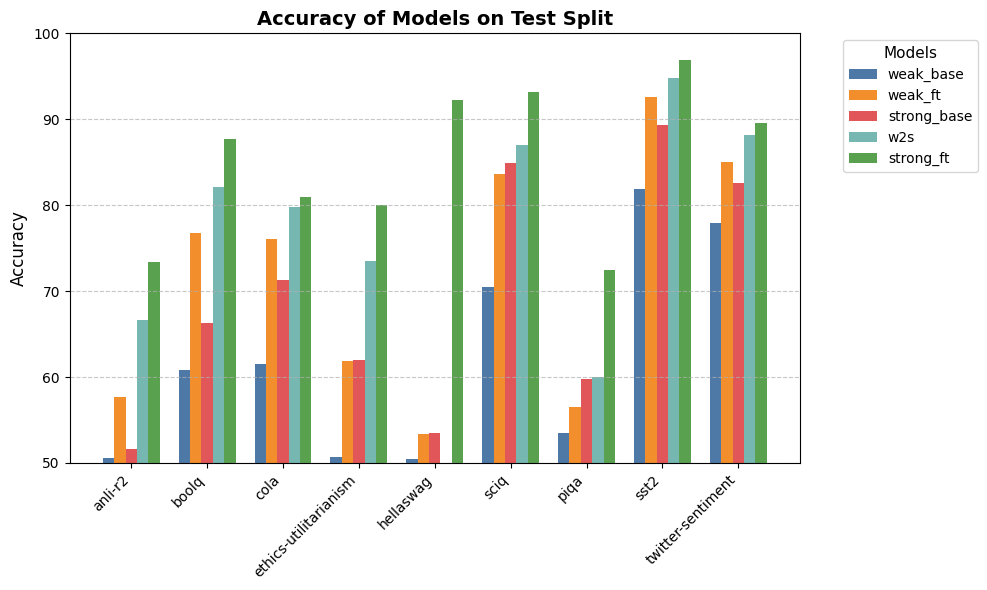

In [4]:
def grouped_bar_plot_accs(preds, exclude_split='test', metric="acc"):
    fig, ax = plt.subplots(figsize=(10, 6))
    barWidth = 0.15  # Narrower bars for better spacing
    r = range(len(datasets))
    
    # Define colors for each model
    colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f']
    
    metric_name, metric_func = "Accuracy", get_acc
    if metric=="auc":\
        metric_name, metric_func = "ROC-AUC", get_auc
    
    for i, mname in enumerate(model_names):
        accs = [get_acc(preds[dname][mname][split]) for dname in datasets]
        ax.bar([x + barWidth * i for x in r], accs, width=barWidth, color=colors[i], label=mname)
    
    # Customize ticks and labels
    ax.set_xticks([x + barWidth * (len(model_names) - 1) / 2 for x in r])
    ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=10)
    ax.set_yticks(range(0, 110, 10))
    
    # Set labels and title with larger font sizes
    ax.set_ylabel(metric_name, fontsize=12)
    ax.set_title(f"{metric_name} of Models on {split.capitalize()} Split", fontsize=14, fontweight='bold')
    ax.set_ylim(50, 100)
    
    # Add grid lines for y-axis
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    # Move legend outside of the plot
    ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize='11')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function
grouped_bar_plot_accs(preds, metric="acc")

{'cc': {'correct': 202, 'total': 219}, 'cw': {'correct': 134, 'total': 166}, 'wc': {'correct': 67, 'total': 126}, 'ww': {'correct': 42, 'total': 157}}
{'cc': {'correct': 1338, 'total': 1386}, 'cw': {'correct': 436, 'total': 512}, 'wc': {'correct': 152, 'total': 255}, 'ww': {'correct': 106, 'total': 321}}
{'cc': {'correct': 363, 'total': 378}, 'cw': {'correct': 75, 'total': 112}, 'wc': {'correct': 50, 'total': 81}, 'ww': {'correct': 26, 'total': 73}}
{'cc': {'correct': 1557, 'total': 1691}, 'cw': {'correct': 726, 'total': 884}, 'wc': {'correct': 502, 'total': 889}, 'ww': {'correct': 275, 'total': 702}}
{'cc': {'correct': 392, 'total': 1442}, 'cw': {'correct': 1119, 'total': 1224}, 'wc': {'correct': 126, 'total': 1233}, 'ww': {'correct': 859, 'total': 1101}}
{'cc': {'correct': 2143, 'total': 2231}, 'cw': {'correct': 194, 'total': 261}, 'wc': {'correct': 197, 'total': 298}, 'ww': {'correct': 58, 'total': 190}}
{'cc': {'correct': 587, 'total': 693}, 'cw': {'correct': 206, 'total': 343}, 'w

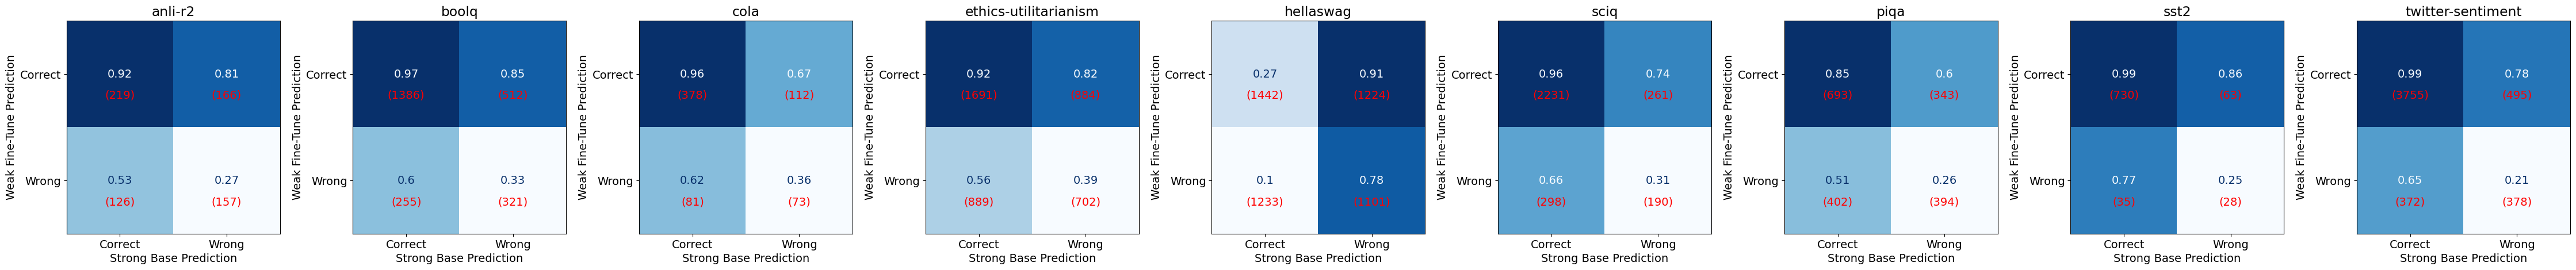

In [50]:
# confusion matrix of weak_ft, strong_base with accuracies of w2s printed in each square along with totals

def conf_mat_accs(preds, split='test'):
    num_datasets = len(preds)
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 5))
    
    # Loop through each dataset and its corresponding axis for subplots
    for idx, (dset, ax) in enumerate(zip(preds, axes)):
        dsref1, dsref2, dsmain = preds[dset]["weak_ft"][split], preds[dset]["strong_base"][split], preds[dset]["w2s"][split]
        dsref1, dsref2, dsmain = add_preds(dsref1), add_preds(dsref2), add_preds(dsmain)
        
        # Calculate accuracy buckets
        buckets = acc_buckets(dsref1, dsref2, dsmain)
        
        # Extract correct and total values
        correct_cc, total_cc = buckets['cc']['correct'], buckets['cc']['total']
        correct_cw, total_cw = buckets['cw']['correct'], buckets['cw']['total']
        correct_wc, total_wc = buckets['wc']['correct'], buckets['wc']['total']
        correct_ww, total_ww = buckets['ww']['correct'], buckets['ww']['total']
        
        # Normalized confusion matrix
        cm = np.array([
            [correct_cc / total_cc if total_cc > 0 else 0, correct_cw / total_cw if total_cw > 0 else 0],
            [correct_wc / total_wc if total_wc > 0 else 0, correct_ww / total_ww if total_ww > 0 else 0]
        ])
        
        # Create text annotations with only total count in brackets
        cm_text = np.array([
            [f"({total_cc})" if total_cc > 0 else "",
             f"({total_cw})" if total_cw > 0 else ""],
            [f"({total_wc})" if total_wc > 0 else "",
             f"({total_ww})" if total_ww > 0 else ""]
        ])
        
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Correct", "Wrong"])
        disp.plot(ax=ax, cmap="Blues", colorbar=False)
        
        # Add custom text annotations slightly below default text
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i + 0.2, cm_text[i, j], ha="center", va="center", color="red")  # Offset y-position slightly

        # Set dataset title and custom axis labels
        ax.set_title(dset)
        ax.set_xlabel("Strong Base Prediction", fontsize=14)
        ax.set_ylabel("Weak Fine-Tune Prediction", fontsize=14)
        plt.rcParams.update({'axes.labelsize': 14})
        plt.tick_params(axis='both', which='major', labelsize=14)

    
    # Adjust layout to fit all subplots well
    plt.tight_layout()
    plt.show()

# Run the function with your data
conf_mat_accs(preds, split='test')


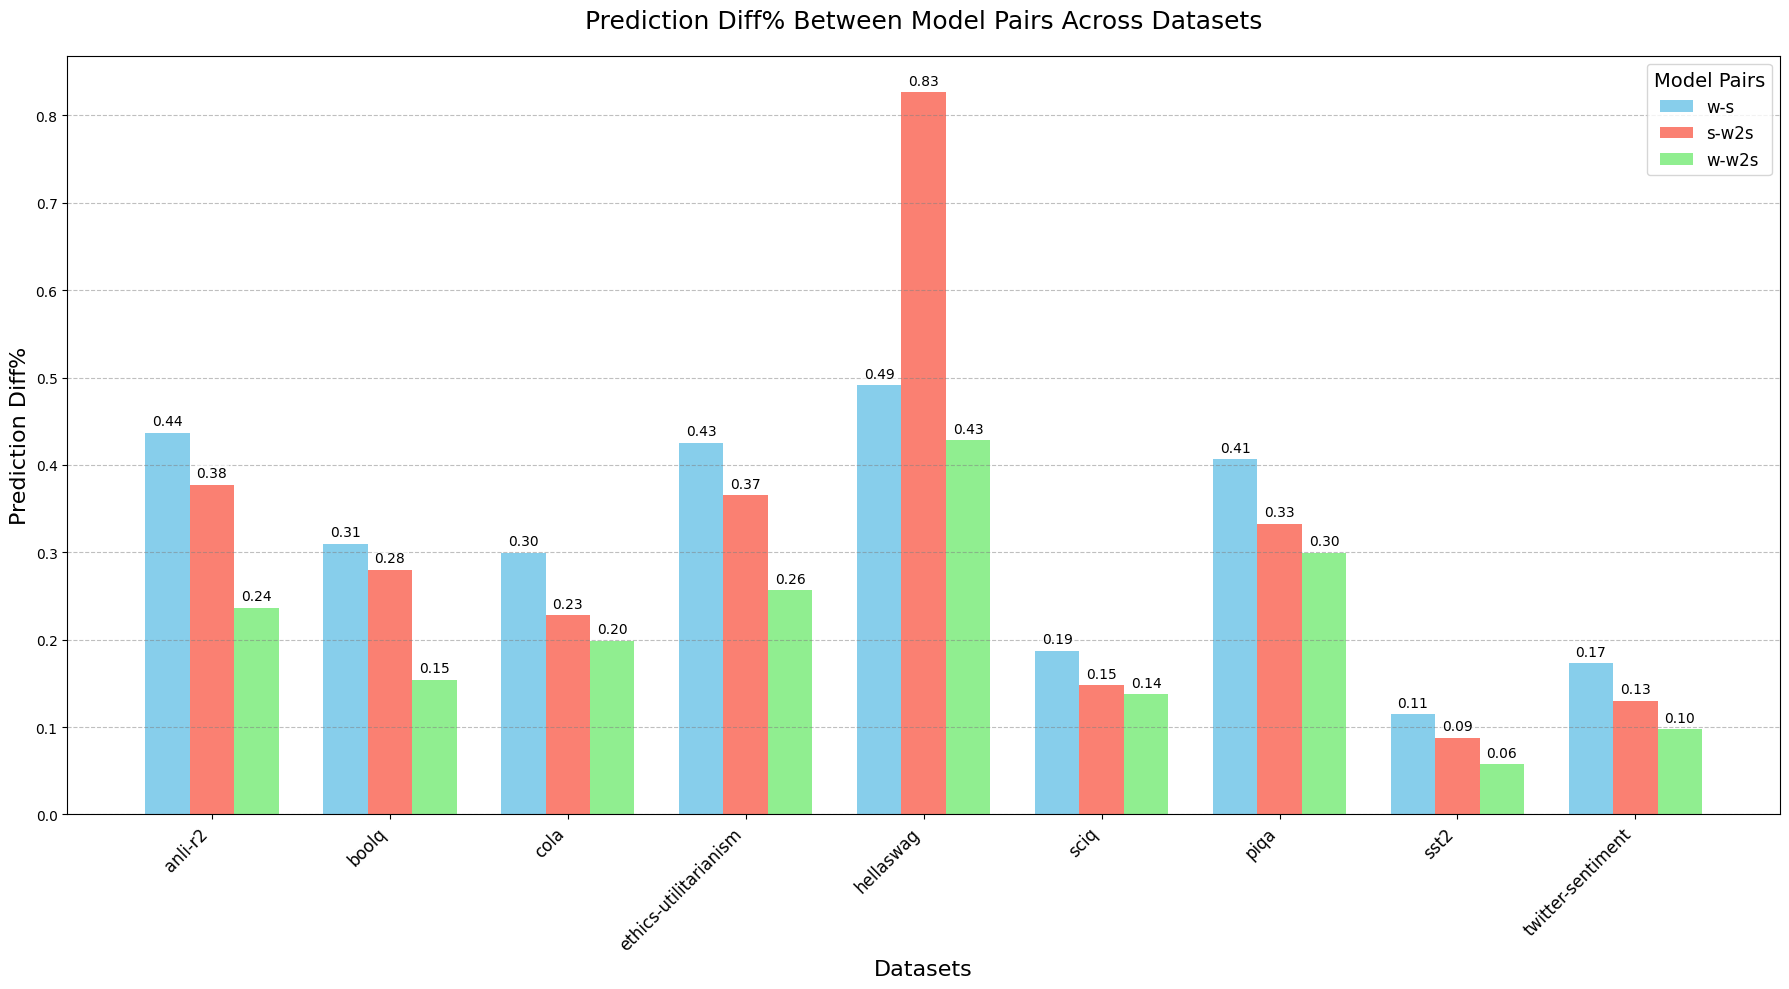

In [3]:
# plot diff metrics: jsd, pred-diff%, kappa vs accuracy gain of w2s model scatter plot across models and datasets
def plot_diff_metric(preds, datasets, metric_func, metric_name, m1name, m2name, m3name, split='test'):
    """
    Plots a grouped bar plot for a given metric across multiple datasets.

    Parameters:
    - preds: Dictionary containing predictions for multiple datasets.
                  Format: dset_preds[dataset][model_name]][split] = prediction_array
    - datasets: List of dataset names.
    - metric_func: Function to calculate the metric (e.g., get_jsd).
    - metric_name: Name of the metric (e.g., "JSD").
    - m1name, m2name, m3name: Names of the three models.
    """
    # Define model pairs and their labels
    model_pairs = [ (m1name, m2name), (m2name, m3name), (m1name, m3name) ]
    pair_labels = ["w-s", "s-w2s", "w-w2s"]
    num_pairs = len(model_pairs)
    x = np.arange(len(datasets))  # Label locations
    width = 0.25  # Width of each bar

    # Initialize lists to hold metric values for each pair
    metrics_per_pair = { label: [] for label in pair_labels }

    # Collect metrics for each model pair across all datasets
    for dset in datasets:
        curr_preds = preds[dset]
        metrics_per_pair["w-s"].append(metric_func(curr_preds[m1name][split], curr_preds[m2name][split]))
        metrics_per_pair["s-w2s"].append(metric_func(curr_preds[m2name][split], curr_preds[m3name][split]))
        metrics_per_pair["w-w2s"].append(metric_func(curr_preds[m1name][split], curr_preds[m3name][split]))

    # Define colors for each model pair
    colors = ['skyblue', 'salmon', 'lightgreen']

    # Create the plot
    fig, ax = plt.subplots(figsize=(18, 10))

    # Plot each model pair's metrics as a separate bar set
    for i, label in enumerate(pair_labels):
        # Offset positions for each pair
        offset = (i - 1) * width  # Positions: -width, 0, +width
        bars = ax.bar(x + offset, metrics_per_pair[label], width, label=label, color=colors[i])

        # Annotate each bar with its height
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, 
                    bar.get_height() + 0.005,  # Slightly above the bar
                    f'{height:.2f}', 
                    ha='center', va='bottom', fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

    # Add labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Datasets', fontsize=16)
    ax.set_ylabel(metric_name, fontsize=16)
    ax.set_title(f'{metric_name} Between Model Pairs Across Datasets', fontsize=18, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=12)
    ax.legend(title='Model Pairs', fontsize=12, title_fontsize=14)

    # Add gridlines for better readability
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

    # Tight layout to accommodate labels and annotations
    plt.tight_layout()
    plt.show()

plot_diff_metric(preds, datasets, get_jsd, "JSD", "weak_ft", "strong_base", "w2s", split='test')
# plot_diff_metric(preds, datasets, get_kappa_mcqs, "Kappa", "weak_ft", "strong_base", "w2s", split='test')
# plot_diff_metric(preds, datasets, get_diffp, "Prediction Diff%", "weak_ft", "strong_base", "w2s", split='test')

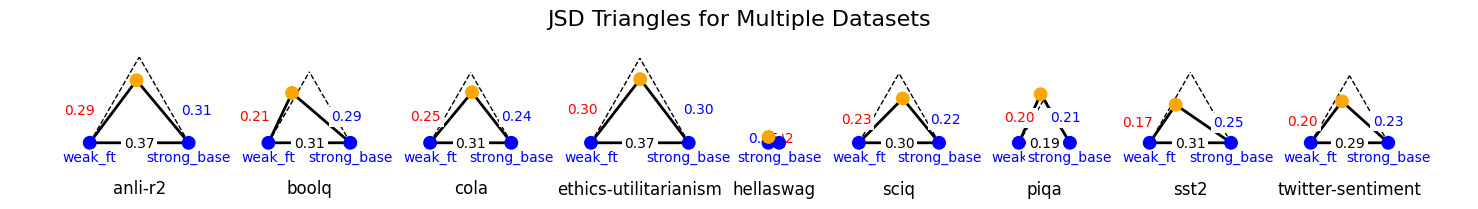

In [49]:
# jsd visualized as triangles
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon

def plot_multiple_triangles(preds, datasets, m1name, m2name, m3name, padding=0.5, split='test'):
    """
    Plots triangles for multiple datasets, where each triangle's sides correspond to JSD values.
    
    Parameters:
    - dset_preds: Dictionary containing predictions for multiple datasets.
    - datasets: List of dataset names.
    - m1name, m2name, m3name: Names of the three models.
    - padding: Horizontal space between consecutive triangles.
    """
    fig, ax = plt.subplots(figsize=(15, 8))
    current_x = 0  # Starting x-coordinate for the first triangle
    max_y = 0      # To adjust y-axis limits

    for dset in datasets:
        dsref1 = preds[dset][m1name][split]
        dsref2 = preds[dset][m2name][split]
        dsmain = preds[dset][m3name][split]
        jsd_1_2 = get_jsd(dsref1, dsref2)
        jsd_1_3 = get_jsd(dsref1, dsmain)
        jsd_2_3 = get_jsd(dsref2, dsmain)

        # Check if the sides can form a valid triangle
        sides = [jsd_1_2, jsd_1_3, jsd_2_3]
        if any(s <= 0 for s in sides):
            print(f"Skipping {dset}: JSD values must be positive.")
            continue
        if not (sides[0] + sides[1] > sides[2] and
                sides[1] + sides[2] > sides[0] and
                sides[0] + sides[2] > sides[1]):
            print(f"Skipping {dset}: JSD values do not satisfy the triangle inequality.")
            continue

        # Base coordinates
        p1 = np.array([current_x, 0])
        p2 = np.array([current_x + jsd_1_2, 0])

        # Apex coordinates
        c = jsd_1_2
        a = jsd_1_3
        b = jsd_2_3

        x3 = (a**2 - b**2 + c**2) / (2 * c)
        y3_squared = a**2 - x3**2
        if y3_squared < 0:
            print(f"Skipping {dset}: Cannot compute triangle coordinates.")
            continue
        y3 = np.sqrt(y3_squared)
        p3 = np.array([current_x + x3, y3])

        # Update max_y for plot limits
        max_y = max(max_y, y3)

        # Plot the actual triangle
        triangle = np.array([p1, p2, p3, p1])
        ax.plot(triangle[:, 0], triangle[:, 1], 'k-', linewidth=2)

        # Scatter points for models
        ax.scatter([p1[0], p2[0], p3[0]],
                   [p1[1], p2[1], p3[1]],
                   color=['blue', 'blue', 'orange'], zorder=5, s=80)

        # *** Add the imaginary equilateral triangle apex and dashed lines ***
        # Calculate coordinates of the imaginary equilateral apex point (p3_eq)
        center_x_eq = (p1[0] + p2[0]) / 2
        h_eq = (np.sqrt(3) / 2) * c
        p3_eq = np.array([center_x_eq, h_eq])

        # Draw dashed lines from p1 and p2 to p3_eq
        ax.plot([p1[0], p3_eq[0]], [p1[1], p3_eq[1]], 'k--', linewidth=1)
        ax.plot([p2[0], p3_eq[0]], [p2[1], p3_eq[1]], 'k--', linewidth=1)

        # Optionally, plot the imaginary apex point
        # ax.scatter(p3_eq[0], p3_eq[1], color='grey', marker='x', s=80)

        # Adjusted positions and styles to prevent overlapping text

        # Annotate JSD values with increased offsets and background boxes
        mid_p1_p2 = (p1 + p2) / 2
        ax.text(mid_p1_p2[0], mid_p1_p2[1] + 0.1 * max_y, f"{jsd_1_2:.2f}",
                ha='center', va='top', fontsize=10,
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

        mid_p1_p3 = (p1 + p3) / 2
        ax.text(mid_p1_p3[0] - 0.5 * c, mid_p1_p3[1] - 0.1 * max_y, f"{jsd_1_3:.2f}",
                ha='left', va='bottom', fontsize=10, color='red',
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

        mid_p2_p3 = (p2 + p3) / 2
        ax.text(mid_p2_p3[0] + 0.5 * c, mid_p2_p3[1] - 0.1 * max_y, f"{jsd_2_3:.2f}",
                ha='right', va='bottom', fontsize=10, color='blue',
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

        # Model labels with increased offsets and background boxes
        ax.text(p1[0], p1[1] - 0.12 * max_y, m1name, ha='center', va='top', fontsize=10, color='blue',
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

        ax.text(p2[0], p2[1] - 0.12 * max_y, m2name, ha='center', va='top', fontsize=10, color='blue',
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

        # ax.text(p3[0] + p3[0] - p3_eq[0], p3[1] + 0.1 * max_y, m3name, ha='center', va='bottom', fontsize=10, color='orange',
        #         bbox=dict(facecolor='white', edgecolor='none', pad=2))

        # Dataset label with increased offset and background box
        center_x = (p1[0] + p2[0]) / 2
        ax.text(center_x, -0.6 * max_y, dset, ha='center', va='top', fontsize=12,
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

        # Update current_x for next triangle
        current_x = p2[0] + padding

    # Adjust plot limits to provide more space
    ax.set_xlim(-padding, current_x)
    ax.set_ylim(-0.25 * max_y, max_y * 1.4)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.title("JSD Triangles for Multiple Datasets", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

plot_multiple_triangles(preds, datasets, "weak_ft", "strong_base", "w2s", padding=0.3, split='test')

In [ ]:
# linear regression of weak_ft, strong_base probabilities on w2s probabilities
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def linear_regression(dset_preds, datasets, m1name, m2name, m3name):
    def get_probs(preds):
        return np.array([pred['probs'] for pred in preds])
    
    # Initialize the linear regression model
    reg = LinearRegression()
    
    # Initialize lists to hold the MSE values for each dataset
    mse_values = []

    # Perform linear regression for each dataset
    for dset in datasets:
        # Get the predictions for each model
        weak_ft_probs = get_probs(dset_preds[dset][m1name])
        strong_base_probs = get_probs(dset_preds[dset][m2name])
        w2s_probs = get_probs(dset_preds[dset][m3name])
        
        # Fit the linear regression model
        reg.fit(w2s_probs, weak_ft_probs)
        
        # Predict the weak_ft probabilities using w2s probabilities
        weak_ft_pred = reg.predict(w2s_probs)
        
        # Calculate the MSE between the predicted and actual weak_ft probabilities
        mse = mean_squared_error(weak_ft_probs, weak_ft_pred)
        mse_values.append(mse)

    # Plot the MSE values for each dataset
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(datasets, mse_values, color='skyblue')
    ax.set_xlabel('Dataset', fontsize=12)
    ax.set_ylabel('Mean Squared Error', fontsize=12)
    ax.set_title('Mean Squared Error of Weak Fine-Tune Predictions', fontsize=14, fontweight='bold')
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    

In [56]:
#check calibation of models
def get_brier(ds):
    labels = np.array([d["labels"] for d in ds])
    preds = np.array([d["soft_pred"] for d in ds])
    return np.mean((labels - preds)**2)

for dset in datasets:
    for mname in model_names:
        print(f"{dset} {mname} Brier: {get_brier(preds[dset][mname]['test']):.4f}")

anli-r2 weak_base Brier: 0.3144
anli-r2 weak_ft Brier: 0.3645
anli-r2 strong_base Brier: 0.2594
anli-r2 w2s Brier: 0.2619
anli-r2 strong_ft Brier: 0.2258
boolq weak_base Brier: 0.2343
boolq weak_ft Brier: 0.1765
boolq strong_base Brier: 0.2131
boolq w2s Brier: 0.1363
boolq strong_ft Brier: 0.0939
cola weak_base Brier: 0.2258
cola weak_ft Brier: 0.1822
cola strong_base Brier: 0.1898
cola w2s Brier: 0.1460
cola strong_ft Brier: 0.1395
ethics-utilitarianism weak_base Brier: 0.2510
ethics-utilitarianism weak_ft Brier: 0.3223
ethics-utilitarianism strong_base Brier: 0.2316
ethics-utilitarianism w2s Brier: 0.1919
ethics-utilitarianism strong_ft Brier: 0.1797
hellaswag weak_base Brier: 0.2503
hellaswag weak_ft Brier: 0.2493
hellaswag strong_base Brier: 0.2482
hellaswag w2s Brier: 0.2557
hellaswag strong_ft Brier: 0.0612
sciq weak_base Brier: 0.1955
sciq weak_ft Brier: 0.1374
sciq strong_base Brier: 0.1138
sciq w2s Brier: 0.0945
sciq strong_ft Brier: 0.0591
piqa weak_base Brier: 0.2496
piqa we